In [19]:
import numpy as np
import matplotlib.pyplot as plt
import random
from scipy.spatial.distance import cdist
from scipy.linalg import expm
from scipy.linalg import logm
from scipy.linalg import eig, eigh
from scipy.linalg import null_space
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import expm_multiply
from scipy.optimize import curve_fit
from scipy.integrate import simps 
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.widgets import Slider

(10, 100)
24.441584587097168


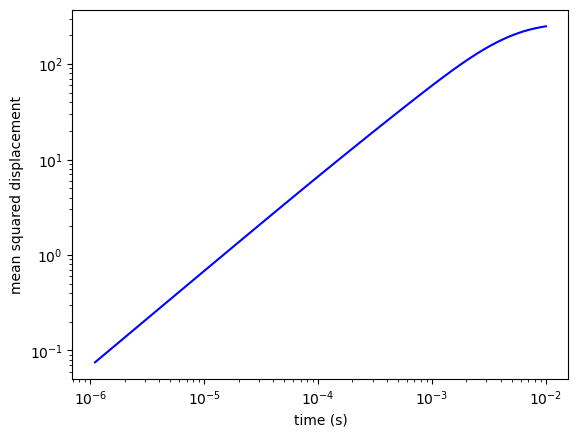

In [426]:
from pathos.multiprocessing import ProcessingPool as Pool

import time
start_time = time.time()

def run_simulation(params):
    
    
    import numpy as np
    from scipy.linalg import eigh
    import random
    
    mu_0 = 1.256e-6 #NA^-2
    hbar = 1.055e-34 #Js
    gamma_C = 10.7084e6 #Hz/T
    gamma_e = 28024.951e6 #Hz/T
    r3 = 16*1e-10 #spin diffusion barrier radius
    
    import numpy as np

    def sample_special_positions(a, size, prob_C, prob_e):
        # Total number of unit cells
        grid_range = np.arange(-size, size + 1)
        Ncells = len(grid_range) ** 3
        Natoms = Ncells * 8  # 8 atoms per FCC diamond unit cell

        # How many atoms to sample
        num_C = int(Natoms * prob_C)
        num_e = int(Natoms * prob_e)
        total_specials = num_C + num_e

        # Sample linear indices (0 to Natoms-1)
        indices = np.random.choice(Natoms, total_specials, replace=False)
        carbon_indices = np.random.choice(indices, num_C, replace=False)
        electron_indices = np.setdiff1d(indices, carbon_indices, assume_unique=True)

        # Convert linear index to (unit cell index, basis atom index)
        unit_index = indices // 8
        basis_index = indices % 8

        # Map unit index back to (l, m, n) grid coordinates
        n_grid = len(grid_range)
        L = unit_index // (n_grid ** 2)
        M = (unit_index // n_grid) % n_grid
        N = unit_index % n_grid
        L = L + grid_range[0]
        M = M + grid_range[0]
        N = N + grid_range[0]

        # FCC + offset basis
        basis = (a/2)*np.array([
            [0, 0, 0],
            [1, 1, 0],
            [1, 0, 1],
            [0, 1, 1],
            [0.5, 0.5, 0.5],
            [1.5, 1.5, 0.5],
            [1.5, 0.5, 1.5],
            [0.5, 1.5, 1.5],
        ])

        # Construct positions
        unit_coords = np.stack([L, M, N], axis=1) * a
        special_positions = unit_coords + basis[basis_index]

        # Split into carbon and electron positions
        carbon_pts = special_positions[np.isin(indices, carbon_indices)]
        e_pts = special_positions[np.isin(indices, electron_indices)]

        return carbon_pts, e_pts

    

    def azimuthal_angle(p1, p2):
        diff = p1 - p2
        norm_diff = diff/np.linalg.norm(diff)
        return np.arccos(norm_diff[2])



    def calculate_M(size, carbon_pts, e_pts, tau_p, tau_d):
        if e_pts.shape[0] == 0:
            outside_pts = carbon_pts
            inside_pts = np.empty((0, 3))
        else:
            diff = carbon_pts[:, np.newaxis, :] - e_pts[np.newaxis, :, :]
            distances = np.linalg.norm(diff, axis=2)
            min_distances = np.min(distances, axis=1)

            inside_pts = carbon_pts[min_distances < r3*1e10]
            outside_pts = carbon_pts[min_distances >= r3*1e10]

        N_carbon = carbon_pts.shape[0]
        N_e = e_pts.shape[0]
        N_bulk = outside_pts.shape[0]
        N_core = inside_pts.shape[0]

        distances = np.sum(outside_pts**2, axis=1)
        min_index = np.argmin(distances)
        closest_pt = outside_pts[min_index]
        shifted_pts = outside_pts - np.array(closest_pt)
        
        #Calculate W matrix
        box_size = 3.57 * (2*size + 1)

        threshold = 20

        W_PBC = np.zeros((N_bulk, N_bulk))
        for i in range(N_bulk - 1):
            for j in range(i + 1, N_bulk):
                diff = outside_pts[i] - outside_pts[j]
                diff = diff - box_size * np.round(diff / box_size) #Periodic boundary conditions
            #     if not np.allclose(diff, outside_pts[i] - outside_pts[j]):
            #         print("PBC adjusted a distance!")
                dist = np.linalg.norm(diff)
                if dist > threshold:
                        W_PBC[i, j] = 0
                        W_PBC[j, i] = 0  # symmetry
                else:    
                    unit_vec = diff / dist
                    angle = np.arccos(unit_vec[2])

                    A = 1 - 3 * (np.cos(angle))**2
                    B = (np.pi * mu_0 * gamma_C**2 * hbar * A) / (2 * (dist * 1e-10)**3)
                    W_PBC[i, j] = 0.5 * B**2 * tau_d
                    W_PBC[j, i] = 0.5 * B**2 * tau_d  # symmetry

        W_PBC = W_PBC - np.diag(np.sum(W_PBC, axis=0))

        M = W_PBC
        return N_bulk, M, shifted_pts, min_index

    
    
    def solve_ode(N_bulk, time, alpha_0, M):
        t_pts = len(time)
        alpha = np.zeros((N_bulk, t_pts))

        evals, evecs = eigh(M)
        V_inv = np.linalg.inv(evecs)

        # max_exp = 1000
        # evals_clipped = np.clip(evals, -max_exp, max_exp)

        V_alpha = V_inv @ alpha_0
#         evals = np.diag(M)
        for t in range(t_pts):
            alpha[:, t] = evecs @ (np.exp(evals * time[t]) * V_alpha)
#             alpha[:, t] = np.exp(evals * time[t])

        return alpha



    def calculate_mean_squared_distance(alpha, points, time):
        squared_distances = np.sum(points**2, axis=1)
        weighted_squares = alpha[:,time] * squared_distances
        mean_squared_distance = np.sum(weighted_squares)
        return mean_squared_distance
    
#     tau_p, tau_d = params
    
    size = 4
    t_pts = 100
    T = np.logspace(-6,-2,t_pts)
    P = np.zeros(len(T))
    carbon_pts, e_pts = sample_special_positions(3.57, size, 30e-2, 0)
    N_bulk, M, shifted_pts, min_index = calculate_M(size, carbon_pts, e_pts, 1, (2.5e-5)*(1/2.4)*100)
#     alpha_0 = (1/N_bulk)*np.ones(N_bulk)
    alpha_0 = np.zeros(N_bulk)
    alpha_0[min_index] = 1
    alpha = solve_ode(N_bulk, T, alpha_0, M)
#     P = np.sum(alpha, axis=0)

    D = np.zeros(t_pts)
    for t in range(t_pts):
        D[t] = calculate_mean_squared_distance(alpha, shifted_pts, t)
        
    return D


iterations = 10
inputs = [(1)] * iterations

pool = Pool()
# pool.restart()
results = pool.map(run_simulation, inputs)

print(np.array(results).shape)
end_time = time.time()
print(end_time-start_time)

T = np.logspace(-6,-2,100)
D_avg = (np.sum(np.array(results), axis=0))/iterations
fig = plt.figure()
plt.loglog(T[1:], D_avg[1:], color='b')
plt.xlabel('time (s)')
plt.ylabel('mean squared displacement')
plt.show()

# np.savez("MSD_0.5_size18_100Itr_v2.npz", time=T, msd=np.array(results))

D = 9.877551743995675e-13 cm^2/s alpha = 0.9871542518042721


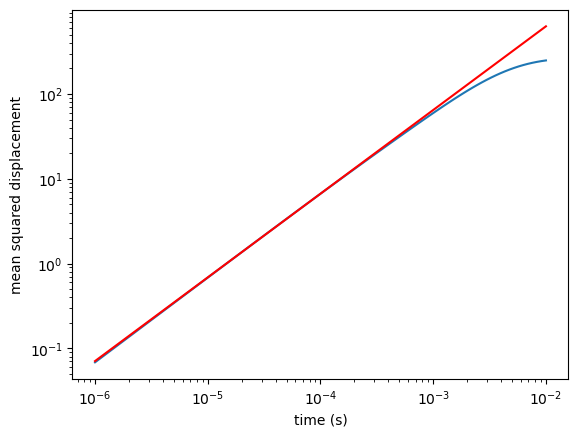

In [427]:
def find_cutoff_index(msd, threshold):
    max_msd = np.max(msd)
    for i in range(len(msd)):
        if msd[i] > threshold * max_msd:
            return i
    return len(msd)

def diffusion_fit(t, alpha, D):
    return 6*D * t**alpha

i_start = 1
i_end = find_cutoff_index(D_avg, 0.03)

time_fit = T[i_start:i_end]
msd_fit = D_avg[i_start:i_end]

popt, pcov = curve_fit(diffusion_fit, time_fit, msd_fit, p0=[1, 1e6])
alpha, D = popt
        
print("D =", D*1e-16, "cm^2/s", "alpha =", alpha)
    
plt.figure()
plt.loglog(T, D_avg)
plt.loglog(T, 6*D * T**alpha, color='r')
plt.xlabel('time (s)')
plt.ylabel('mean squared displacement')
plt.show()

(1, 100)
50.61280632019043


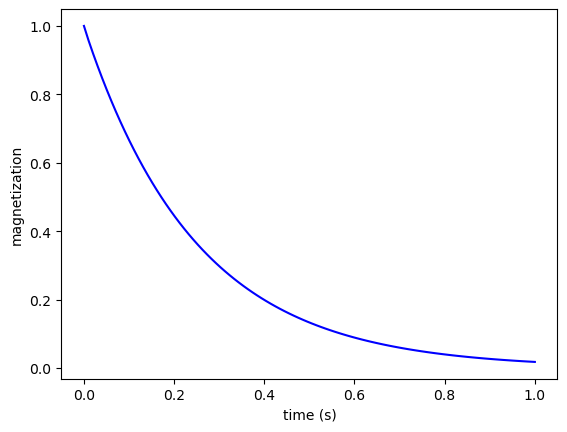

In [15]:
from pathos.multiprocessing import ProcessingPool as Pool

import time
start_time = time.time()

def run_simulation(params):
    
    
    import numpy as np
    from scipy.linalg import eigh
    import random
    
    mu_0 = 1.256e-6 #NA^-2
    hbar = 1.055e-34 #Js
    gamma_C = 10.7084e6 #Hz/T
    gamma_e = 28024.951e6 #Hz/T
    r3 = 16*1e-10 #spin diffusion barrier radius
    
    def sample_special_positions(a, size, prob_C, prob_e):
        # Total number of unit cells
        grid_range = np.arange(-size, size + 1)
        Ncells = len(grid_range) ** 3
        Natoms = Ncells * 8  # 8 atoms per FCC diamond unit cell

        # How many atoms to sample
        num_C = int(Natoms * prob_C)
        num_e = int(Natoms * prob_e)
        total_specials = num_C + num_e

        # Sample linear indices (0 to Natoms-1)
        indices = np.random.choice(Natoms, total_specials, replace=False)
        carbon_indices = np.random.choice(indices, num_C, replace=False)
        electron_indices = np.setdiff1d(indices, carbon_indices, assume_unique=True)

        # Convert linear index to (unit cell index, basis atom index)
        unit_index = indices // 8
        basis_index = indices % 8

        # Map unit index back to (l, m, n) grid coordinates
        n_grid = len(grid_range)
        L = unit_index // (n_grid ** 2)
        M = (unit_index // n_grid) % n_grid
        N = unit_index % n_grid
        L = L + grid_range[0]
        M = M + grid_range[0]
        N = N + grid_range[0]

        # FCC + offset basis
        basis = (a/2)*np.array([
            [0, 0, 0],
            [1, 1, 0],
            [1, 0, 1],
            [0, 1, 1],
            [0.5, 0.5, 0.5],
            [1.5, 1.5, 0.5],
            [1.5, 0.5, 1.5],
            [0.5, 1.5, 1.5],
        ])

        # Construct positions
        unit_coords = np.stack([L, M, N], axis=1) * a
        special_positions = unit_coords + basis[basis_index]

        # Split into carbon and electron positions
        carbon_pts = special_positions[np.isin(indices, carbon_indices)]
        e_pts = special_positions[np.isin(indices, electron_indices)]

        return carbon_pts, e_pts
   



    def azimuthal_angle(p1, p2):
        diff = p1 - p2
        norm_diff = diff/np.linalg.norm(diff)
        return np.arccos(norm_diff[2])



    def calculate_M(size, carbon_pts, e_pts, tau_p, tau_d):
        diff = carbon_pts[:, np.newaxis, :] - e_pts[np.newaxis, :, :]
        distances = np.linalg.norm(diff, axis=2)
        min_distances = np.min(distances, axis=1)

        inside_pts = carbon_pts[min_distances < r3*1e10]
        outside_pts = carbon_pts[min_distances >= r3*1e10]

        N_carbon = carbon_pts.shape[0]
        N_e = e_pts.shape[0]
        N_bulk = outside_pts.shape[0]
        N_core = inside_pts.shape[0]

        #Calculate R matrix

        #Calculate distances and azimuthal angles between carbon and every electron around it for each carbon 
        #(already similarly done 3 cells above)
#         diff2 = outside_pts[:, np.newaxis, :] - e_pts[np.newaxis, :, :]
#         distances2 = np.linalg.norm(diff2, axis=2)

        box_size = 3.57 * (2*size + 1)
        
        R = np.zeros((N_bulk))
        rates = np.zeros((N_e))
        for carbon in range(N_bulk):
            for e in range(N_e):
#                 r = distances2[carbon,e]
                diff_r = outside_pts[carbon] - e_pts[e]
                diff_r = diff_r - box_size * np.round(diff_r / box_size)
                r = np.linalg.norm(diff_r)
            
                unit_vec = diff_r / r
                angle = np.arccos(unit_vec[2])
#                 angle = azimuthal_angle(outside_pts[carbon], e_pts[e])
                D = 1 - 3*(np.cos(angle))**2 
                C = ((np.pi)*mu_0*gamma_C*gamma_e*hbar*D)/(2*((r*1e-10)**3))
                rates[e] = (1/2)*(C**2)*tau_p
            R[carbon] = np.sum(rates)
            rates = np.zeros((N_e))

        R = np.diag(R)

        #Calculate W matrix
        threshold = 20

        W_PBC = np.zeros((N_bulk, N_bulk))
        for i in range(N_bulk - 1):
            for j in range(i + 1, N_bulk):
                diff = outside_pts[i] - outside_pts[j]
                diff = diff - box_size * np.round(diff / box_size) #Periodic boundary conditions
            #     if not np.allclose(diff, outside_pts[i] - outside_pts[j]):
            #         print("PBC adjusted a distance!")
                dist = np.linalg.norm(diff)
                if dist > threshold:
                        W_PBC[i, j] = 0
                        W_PBC[j, i] = 0  # symmetry
                else:    
                    unit_vec = diff / dist
                    angle = np.arccos(unit_vec[2])

                    A = 1 - 3 * (np.cos(angle))**2
                    B = (np.pi * mu_0 * gamma_C**2 * hbar * A) / (2 * (dist * 1e-10)**3)
                    W_PBC[i, j] = 0.5 * B**2 * tau_d
                    W_PBC[j, i] = 0.5 * B**2 * tau_d  # symmetry

        W_PBC = W_PBC - np.diag(np.sum(W_PBC, axis=0))

        M = W_PBC - R
        return N_bulk, M



    def solve_ode(N_bulk, time, alpha_0, M):
        t_pts = len(time)
        alpha = np.zeros((N_bulk, t_pts))

        evals, evecs = eigh(M)
        V_inv = np.linalg.inv(evecs)

        # max_exp = 1000
        # evals_clipped = np.clip(evals, -max_exp, max_exp)

        V_alpha = V_inv @ alpha_0
#         evals = np.diag(M)
        for t in range(t_pts):
            alpha[:, t] = evecs @ (np.exp(evals * time[t]) * V_alpha)
#             alpha[:, t] = np.exp(evals * time[t])

        return alpha
    
    
    tau_p, tau_d = params
    
    size = 6
    T = np.linspace(0,1,100)
    P = np.zeros(len(T))
    carbon_pts, e_pts = sample_special_positions(3.57, size, 30e-2, 200e-6)
    N_bulk, M = calculate_M(size, carbon_pts, e_pts, tau_p, tau_d)
    alpha_0 = (1/N_bulk)*np.ones(N_bulk)
    alpha = solve_ode(N_bulk, T, alpha_0, M)
    P = np.sum(alpha, axis=0)
    return P


iterations = 1
inputs = [(1.75e-8, (2.5e-5)*(1/2.4)*100)] * iterations

pool = Pool()
# pool.restart()
results = pool.map(run_simulation, inputs)

print(np.array(results).shape)
end_time = time.time()
print(end_time-start_time)

T = np.linspace(0,1,100)
P = np.array(results)
P_avg = (np.sum(P, axis=0))/iterations
fig = plt.figure()
plt.plot(T, P_avg, color='b')
plt.xlabel('time (s)')
plt.ylabel('magnetization')
plt.show()

RMSE product: 0.0001907494283465937


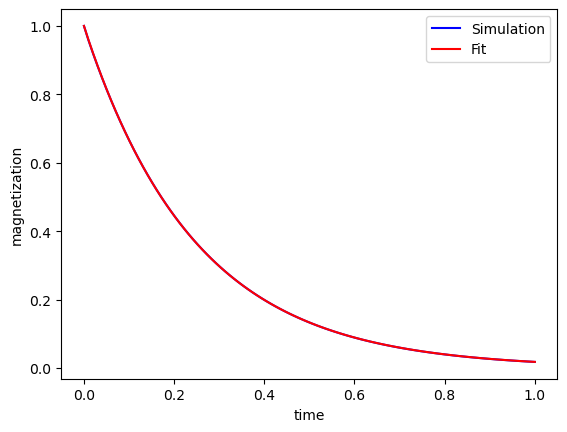

In [16]:
def product_exp(x, a, b):
    return np.exp(-np.sqrt(a*x))*np.exp(-b*x)

def purely_stretched(x, a):
    return np.exp(-np.sqrt(a*x)) 

def monoexp(x, a):
    return np.exp(-a*x)

# Fit the data
popt, pcov = curve_fit(product_exp, T, P_avg, bounds=([0, 0], [100, 100]))

# # popt = optimal values for a, b, c
# print("Fitted parameters:", popt)
# # Optional: Get standard deviation errors
# perr = np.sqrt(np.diag(pcov))
# print("Parameter errors:", perr)

y_fit = product_exp(T, *popt)
residuals = P_avg - y_fit
rmse_product = np.sqrt(np.mean(residuals**2))
print("RMSE product:", rmse_product)

# Plot the data and the fitted curve
fig = plt.figure()
plt.plot(T, P_avg, color='b', label="Simulation")
plt.plot(T, product_exp(T, *popt), color='red', label="Fit")
# plt.semilogy(np.sqrt(T), P_avg, color='b', label="Simulation")
# plt.semilogy(np.sqrt(T), product_exp(T, *popt), color='red', label="Fit")
plt.legend()
plt.xlabel("time")
plt.ylabel("magnetization")
plt.show()

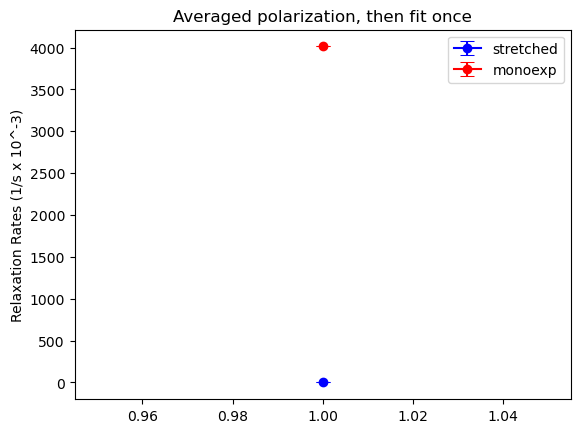

stretched rate = 0.21451478656644604 \pm 0.0
mono rate = 4012.7672072751748 \pm 0.0


In [17]:
def fit_product(P,T):
    from scipy.optimize import curve_fit
    def product_exp(x, a, b):
        return np.exp(-np.sqrt(a*x))*np.exp(-b*x)

    popt, pcov = curve_fit(product_exp, T, P, bounds=([0, 0], [100, 100]))
    stretched_rate = popt[0]*1e3
    mono_rate = popt[1]*1e3
    return stretched_rate, mono_rate

stretched_avg, mono_avg = fit_product(P_avg,T)

stretched_rate = np.zeros((iterations))
mono_rate = np.zeros((iterations))

for j in range(iterations):
    stretched_rate[j], mono_rate[j] = fit_product(P[j,:],T)
    
stretched_mean = np.mean(stretched_rate)
mono_mean = np.mean(mono_rate)

stretched_error = (np.sqrt(np.var(stretched_rate)/iterations))
mono_error = (np.sqrt(np.var(mono_rate)/iterations))

fig = plt.figure()
plt.errorbar(1, stretched_avg, stretched_error, fmt='-o', capsize=5, capthick=0.75, color = 'blue', label = 'stretched')
plt.errorbar(1, mono_avg, mono_error, fmt='-o', capsize=5, capthick=0.75, color = 'red', label = 'monoexp') 
plt.title("Averaged polarization, then fit once")
# plt.xlabel("1/tau_c (1/s)")
plt.ylabel("Relaxation Rates (1/s x 10^-3)")
plt.legend()
plt.show()

print("stretched rate =", stretched_avg, "\pm", stretched_error)
print("mono rate =", mono_avg, "\pm", mono_error)

# filename = f"D=1e-13_RelaxationRates.npz"
# np.savez(filename, S = stretched_rate, M = mono_rate, S_avg = stretched_avg, M_avg = mono_avg)

# fig.savefig("C:\\Users\\Suber\\Desktop\\Regime1_new.eps", format='eps', dpi=300)

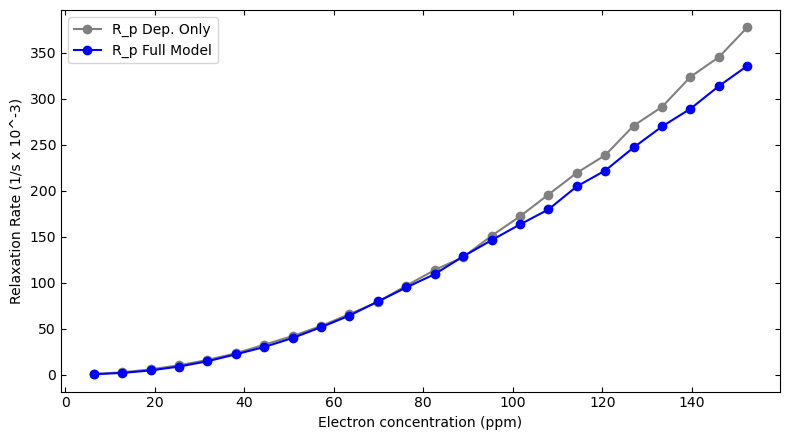

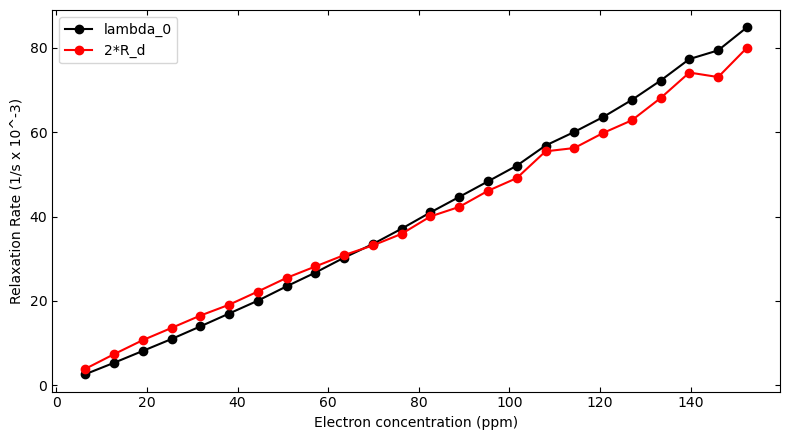

In [14]:
# Load the data (assuming it's space or tab-delimited)
data = np.loadtxt('ev_scaling.txt')

# Extract columns
x = data[:, 0]         # Electron concentration (x-axis)
y1 = data[:, 1]        # Rp Dep. Only
y2 = data[:, 2]        # Rp Full Model
y3 = data[:, 3]        # lambda_min
y4 = data[:, 4]        # 2*R_d

# Plot 1: Columns 2–3 vs. Column 1
fig = plt.figure(figsize=(8, 4.5))
plt.plot(x, y1, marker='o', color='gray', label='R_p Dep. Only')
plt.plot(x, y2, marker='o', color='blue', label='R_p Full Model')
plt.tick_params(direction='in')  # for both x and y
plt.tick_params(top=True, right=True)
plt.xlabel('Electron concentration (ppm)')
plt.ylabel('Relaxation Rate (1/s x 10^-3)')
# plt.title('Columns 2 and 3 vs Electron Concentration')
plt.legend()
# plt.grid(True)
plt.tight_layout()
plt.show()

# Plot 2: Columns 4–5 vs. Column 1
fig = plt.figure(figsize=(8, 4.5))
plt.plot(x, y3, marker='o', color='black', label='lambda_0')
plt.plot(x, y4, marker='o', color='red', label='2*R_d')
plt.tick_params(direction='in')  # for both x and y
plt.tick_params(top=True, right=True)
plt.xlabel('Electron concentration (ppm)')
plt.ylabel('Relaxation Rate (1/s x 10^-3)')
# plt.title('Columns 4 and 5 vs Electron Concentration')
plt.legend()
# plt.grid(True)
plt.tight_layout()
plt.show()

# fig.savefig("C:\\Users\\Suber\\Desktop\\Mono_EV_Scaling.eps", format='eps', dpi=300)

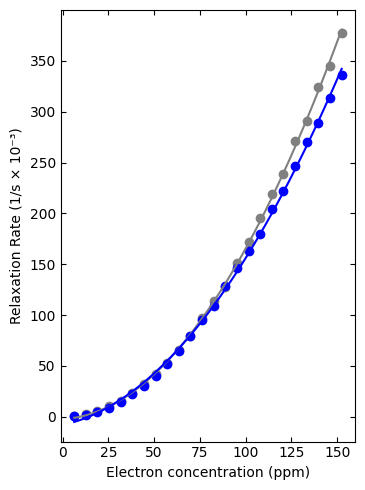

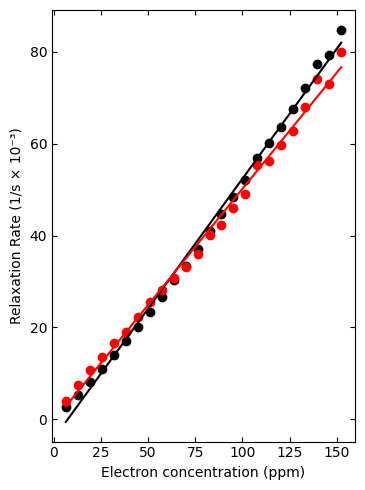

In [20]:
import numpy as np
import matplotlib.pyplot as plt

# Load the data
data = np.loadtxt('ev_scaling.txt')

# Extract columns
x = data[:, 0]         # Electron concentration (ppm)
y1 = data[:, 1]        # Rp Dep. Only
y2 = data[:, 2]        # Rp Full Model
y3 = data[:, 3]        # lambda_min
y4 = data[:, 4]        # 2*R_d

### === Plot 1: y1 and y2 (Linear Fits) ===
fig = plt.figure(figsize=(3.75, 5))

# Linear fits
fit_y1 = np.poly1d(np.polyfit(x, y1, deg=2))
fit_y2 = np.poly1d(np.polyfit(x, y2, deg=2))

# Plot data
plt.plot(x, y1, 'o', color='gray', label='R_p Dep. Only')
plt.plot(x, y2, 'o', color='blue', label='R_p Full Model')

# Plot fits
x_fit = np.linspace(np.min(x), np.max(x), 200)
plt.plot(x_fit, fit_y1(x_fit), '-', color='gray', label='Fit: R_p Dep. Only')
plt.plot(x_fit, fit_y2(x_fit), '-', color='blue', label='Fit: R_p Full Model')

# Axes
plt.tick_params(direction='in', top=True, right=True)
plt.xlabel('Electron concentration (ppm)')
plt.ylabel('Relaxation Rate (1/s × 10⁻³)')
# plt.legend()
plt.tight_layout()
plt.show()

# fig.savefig("C:\\Users\\Suber\\Desktop\\Stretched_EV_Scaling_v2.eps", format='eps', dpi=300)

### === Plot 2: y3 and y4 (Quadratic Fits) ===
fig = plt.figure(figsize=(3.75, 5))

# Quadratic fits
fit_y3 = np.poly1d(np.polyfit(x, y3, deg=1))
fit_y4 = np.poly1d(np.polyfit(x, y4, deg=1))

# Plot data
plt.plot(x, y3, 'o', color='black', label='λ₀')
plt.plot(x, y4, 'o', color='red', label='2·R_d')

# Plot fits
plt.plot(x_fit, fit_y3(x_fit), color='black', label='Fit: λ₀')
plt.plot(x_fit, fit_y4(x_fit), color='red', label='Fit: 2·R_d')

# Axes
plt.tick_params(direction='in', top=True, right=True)
plt.xlabel('Electron concentration (ppm)')
plt.ylabel('Relaxation Rate (1/s × 10⁻³)')
# plt.legend()
plt.tight_layout()
plt.show()

# fig.savefig("C:\\Users\\Suber\\Desktop\\Mono_EV_Scaling_v2.eps", format='eps', dpi=300)

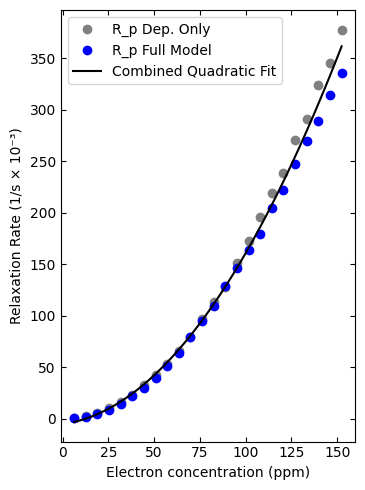

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


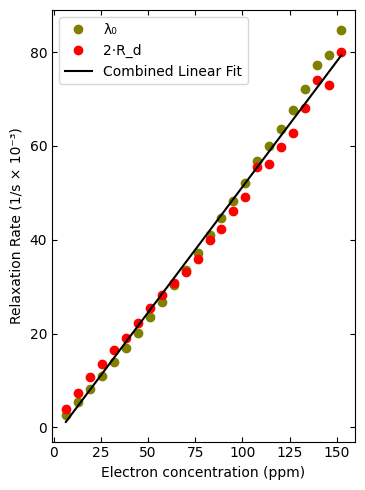

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


Combined Quadratic Fit Coefficients (a, b, c): [ 0.01423897  0.23496561 -5.19892215]
Combined Linear Fit Coefficients (m, b): [ 0.53507408 -2.25101234]


In [34]:
import numpy as np
import matplotlib.pyplot as plt

# === Load the data ===
data = np.loadtxt('ev_scaling.txt')

# === Extract columns ===
x = data[:, 0]         # Electron concentration (ppm)
y1 = data[:, 1]        # R_p Dep. Only
y2 = data[:, 2]        # R_p Full Model
y3 = data[:, 3]        # lambda_min
y4 = data[:, 4]        # 2*R_d

# === Combined Quadratic Fit: y1 and y2 ===
x_quad = np.concatenate([x, x])
y_quad = np.concatenate([y1, y2])
fit_quad = np.poly1d(np.polyfit(x_quad, y_quad, deg=2))

# === Combined Linear Fit: y3 and y4 ===
x_lin = np.concatenate([x, x])
y_lin = np.concatenate([y3, y4])
fit_lin = np.poly1d(np.polyfit(x_lin, y_lin, deg=1))

# === Generate x values for smooth curve ===
x_fit = np.linspace(np.min(x), np.max(x), 200)

# === Plot 1: Quadratic Fit (y1 and y2) ===
fig = plt.figure(figsize=(3.75, 5))

plt.plot(x, y1, 'o', color='gray', label='R_p Dep. Only')
plt.plot(x, y2, 'o', color='blue', label='R_p Full Model')

# Combined fit
plt.plot(x_fit, fit_quad(x_fit), '-', color='black', label='Combined Quadratic Fit')

plt.tick_params(direction='in', top=True, right=True)
plt.xlabel('Electron concentration (ppm)')
plt.ylabel('Relaxation Rate (1/s × 10⁻³)')
plt.legend()
plt.tight_layout()
plt.show()

# fig.savefig("C:\\Users\\Suber\\Desktop\\Stretched_EV_Scaling_v2.eps", format='eps', dpi=300)

# === Plot 2: Linear Fit (y3 and y4) ===
fig = plt.figure(figsize=(3.75, 5))

plt.plot(x, y3, 'o', color='olive', label='λ₀')
plt.plot(x, y4, 'o', color='red', label='2·R_d')

# Combined fit
plt.plot(x_fit, fit_lin(x_fit), color='black', label='Combined Linear Fit')

plt.tick_params(direction='in', top=True, right=True)
plt.xlabel('Electron concentration (ppm)')
plt.ylabel('Relaxation Rate (1/s × 10⁻³)')
plt.legend()
plt.tight_layout()
plt.show()

# === Print Fit Coefficients ===
print("Combined Quadratic Fit Coefficients (a, b, c):", fit_quad.coefficients)
print("Combined Linear Fit Coefficients (m, b):", fit_lin.coefficients)

# fig.savefig("C:\\Users\\Suber\\Desktop\\Mono_EV_Scaling_v2.eps", format='eps', dpi=300)

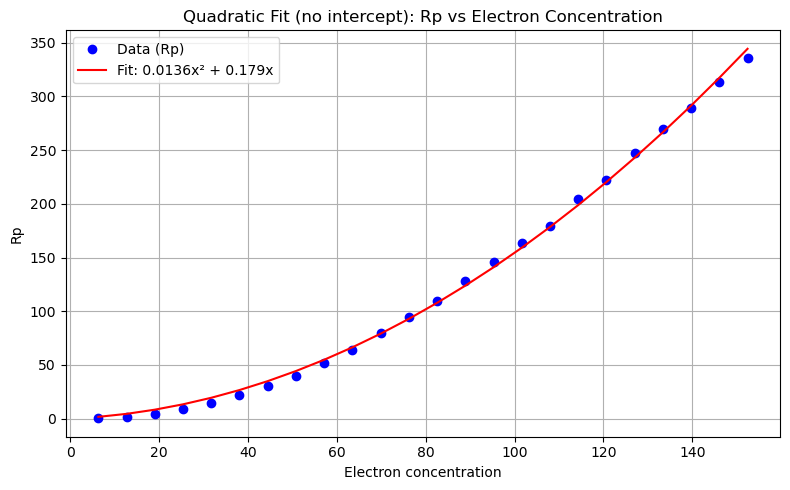

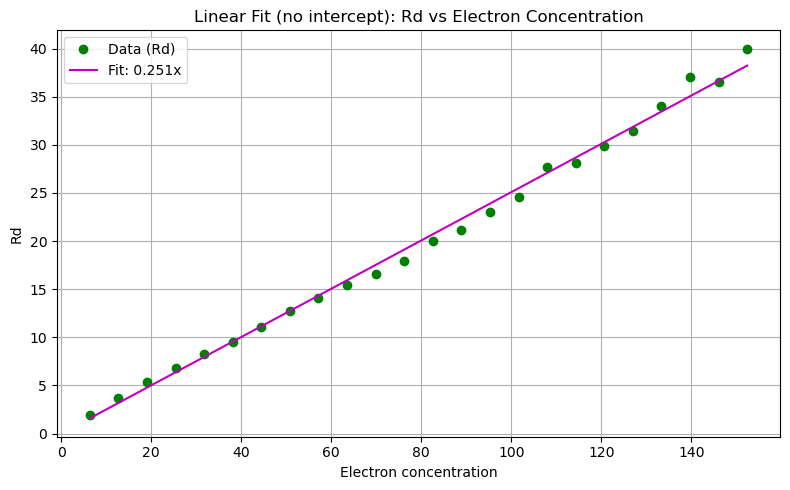

In [23]:
import numpy as np
import matplotlib.pyplot as plt

# Load the data
data = np.loadtxt('ev_scaling.txt')
x = data[:, 0]       # Electron concentration
Rp = data[:, 2]      # Column 3, renamed to Rp
Rd = data[:, 4] / 2  # Column 5, renamed to Rd

# ---- Fit Rp to quadratic with zero intercept: Rp = a*x^2 + b*x ----
X_Rp = np.vstack([x**2, x]).T  # design matrix with no constant column
coeffs_Rp, residuals, rank, s = np.linalg.lstsq(X_Rp, Rp, rcond=None)
# coeffs_Rp = [a, b]

def fit_Rp(x_val):
    return coeffs_Rp[0] * x_val**2 + coeffs_Rp[1] * x_val

# ---- Fit Rd to linear with zero intercept: Rd = a*x ----
X_Rd = x[:, None]  # design matrix with single predictor, no intercept
coeffs_Rd, residuals, rank, s = np.linalg.lstsq(X_Rd, Rd, rcond=None)
# coeffs_Rd = [a]

def fit_Rd(x_val):
    return coeffs_Rd[0] * x_val

# ---- Plotting ----

# Rp plot
plt.figure(figsize=(8, 4.5))
plt.plot(x, Rp, 'bo', label='Data (Rp)')
plt.plot(x, fit_Rp(x), 'r-', label=f'Fit: {coeffs_Rp[0]:.3g}x² + {coeffs_Rp[1]:.3g}x')
plt.xlabel('Electron concentration')
plt.ylabel('Rp')
plt.title('Quadratic Fit (no intercept): Rp vs Electron Concentration')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Rd plot
plt.figure(figsize=(8, 4.5))
plt.plot(x, Rd, 'go', label='Data (Rd)')
plt.plot(x, fit_Rd(x), 'm-', label=f'Fit: {coeffs_Rd[0]:.3g}x')
plt.xlabel('Electron concentration')
plt.ylabel('Rd')
plt.title('Linear Fit (no intercept): Rd vs Electron Concentration')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


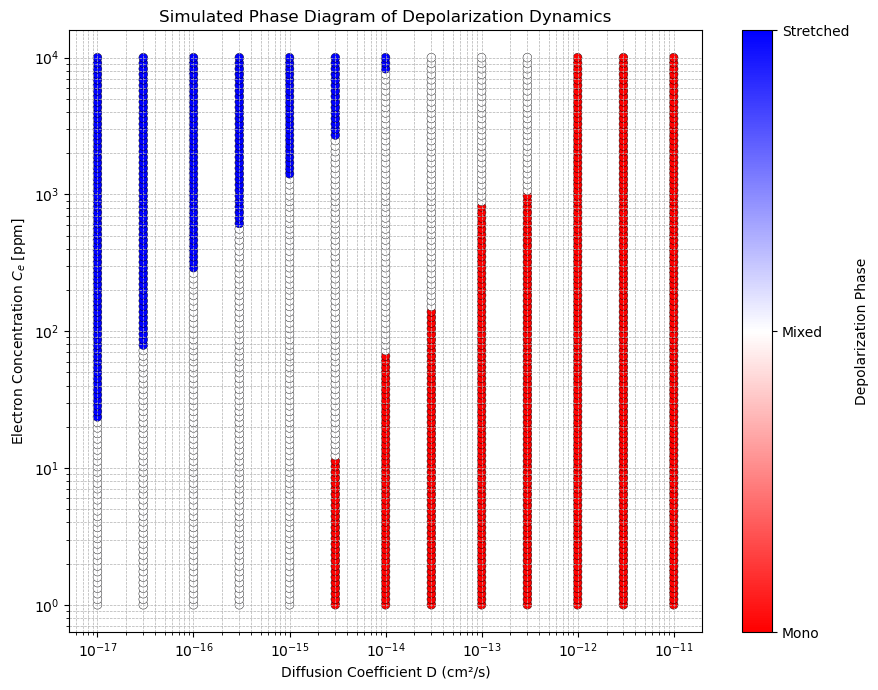

In [6]:
import numpy as np
import glob
import re
import matplotlib.pyplot as plt

# === Define electron concentration grid (in ppm) ===
Ce_grid = np.logspace(0, 4, 100)  # 10 to 1000 ppm

# === Load simulated Rp and Rd at Ce = 200 ppm from files ===
D_values = []
Rp_200ppm = []
Rd_200ppm = []

for file in glob.glob("D=*e*_RelaxationRates.npz"):
    match = re.search(r"D=([\d.eE+-]+)_RelaxationRates.npz", file)
    if not match:
        continue
    D = float(match.group(1))

    data = np.load(file)
    Rp = data['S_avg'].item()
    Rd = data['M_avg'].item()

    if Rp <= 0 or Rd <= 0:
        continue

    D_values.append(D)
    Rp_200ppm.append(Rp)
    Rd_200ppm.append(Rd)

# Sort by D
D_values = np.array(D_values)
Rp_200ppm = np.array(Rp_200ppm) / 1000
Rd_200ppm = np.array(Rd_200ppm) / 1000

sorted_indices = np.argsort(D_values)
D_values = D_values[sorted_indices]
Rp_200ppm = Rp_200ppm[sorted_indices]
Rd_200ppm = Rd_200ppm[sorted_indices]

# === Rescale Rp and Rd using fits to all Ce values ===
# Assumes fit_Rp and fit_Rd are defined earlier
scale_Rp = fit_Rp(Ce_grid) / fit_Rp(200)
scale_Rd = fit_Rd(Ce_grid) / fit_Rd(200)

scale_Rp = np.nan_to_num(scale_Rp, nan=0.0, posinf=0.0, neginf=0.0)
scale_Rd = np.nan_to_num(scale_Rd, nan=0.0, posinf=0.0, neginf=0.0)

Rp_grid = np.outer(Rp_200ppm, scale_Rp)
Rd_grid = np.outer(Rd_200ppm, scale_Rd)

# === Compute Rp/Rd and classify into phases ===
ratio_grid = Rp_grid / Rd_grid

# Flatten everything for scatter plot
D_vals_flat = np.repeat(D_values, len(Ce_grid))        # shape: (len(D) * len(Ce),)
Ce_vals_flat = np.tile(Ce_grid, len(D_values))         # shape: (len(D) * len(Ce),)
ratio_flat = ratio_grid.flatten()

# Phase classification
phase_flat = np.zeros_like(ratio_flat, dtype=int)
phase_flat[(ratio_flat >= 0.1) & (ratio_flat <= 10)] = 1
phase_flat[ratio_flat > 10] = 2

# === Plot ===
plt.figure(figsize=(9, 7))
scatter = plt.scatter(D_vals_flat, Ce_vals_flat, c=phase_flat, cmap='bwr_r', s=40, edgecolors='k', linewidth=0.3)

# Colorbar
cbar = plt.colorbar(scatter, ticks=[0, 1, 2])
cbar.ax.set_yticklabels(['Mono', 'Mixed', 'Stretched'])
cbar.set_label('Depolarization Phase')

# Axis formatting
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Diffusion Coefficient D (cm²/s)')
plt.ylabel('Electron Concentration $C_e$ [ppm]')
plt.title('Simulated Phase Diagram of Depolarization Dynamics')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()


In [7]:
print(Rp_200ppm, Rd_200ppm)

[0.54639384 0.55967433 0.419221   0.52622255 0.53474209 0.2782102
 0.22669863 0.16997388 0.05456964 0.10115468 0.00494585 0.0055281
 0.00192092] [9.39670834e-03 2.41764733e-02 5.48761007e-02 1.47038798e-01
 3.31685475e-01 3.30497046e-01 8.52616743e-01 1.28717279e+00
 2.24668809e+00 4.82477972e+00 8.61463347e+00 1.34434579e+01
 2.46693066e+01]


C:\Users\Suber\AppData\Local\Temp\ipykernel_6092\1720872465.py:66: UserWarning: The following kwargs were not used by contour: 'shading'
  im = plt.contourf(D_mesh, Ce_mesh, log_ratio_grid, shading='auto', levels=200, cmap='bwr_r', norm=norm)


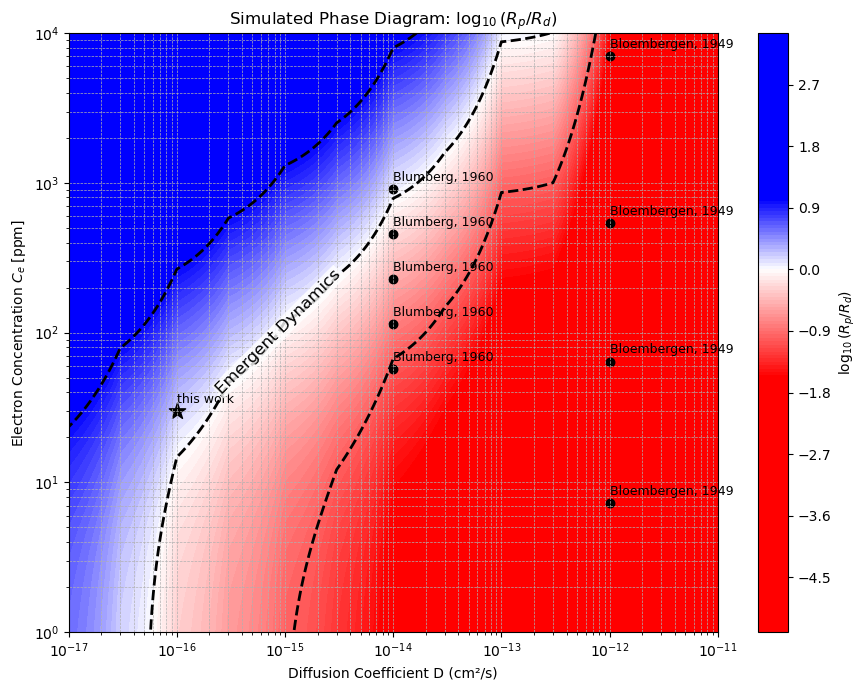

In [19]:
import numpy as np
import glob
import re
from matplotlib.colors import TwoSlopeNorm

# === Define electron concentration grid (in ppm) ===
Ce_grid = np.logspace(0, 4, 1000)  # 10 to 1000 ppm

# === Load simulated Rp and Rd at Ce = 200 ppm from files ===
D_values = []
Rp_200ppm = []
Rd_200ppm = []

for file in glob.glob("D=*e*_RelaxationRates.npz"):
    match = re.search(r"D=([\d.eE+-]+)_RelaxationRates.npz", file)
    if not match:
        continue
    D = float(match.group(1))

    data = np.load(file)
    Rp = data['S_avg'].item()
    Rd = data['M_avg'].item()

    if Rp <= 0 or Rd <= 0:
        continue

    D_values.append(D)
    Rp_200ppm.append(Rp)
    Rd_200ppm.append(Rd)

# Convert to arrays and sort by D
D_values = np.array(D_values)
Rp_200ppm = np.array(Rp_200ppm) / 1000
Rd_200ppm = np.array(Rd_200ppm) / 1000

sorted_indices = np.argsort(D_values)
D_values = D_values[sorted_indices]
Rp_200ppm = Rp_200ppm[sorted_indices]
Rd_200ppm = Rd_200ppm[sorted_indices]

# === Rescale using fit functions (defined earlier in your code) ===
scale_Rp = fit_Rp(Ce_grid) / fit_Rp(200)
scale_Rd = fit_Rd(Ce_grid) / fit_Rd(200)

scale_Rp = np.nan_to_num(scale_Rp, nan=0.0, posinf=0.0, neginf=0.0)
scale_Rd = np.nan_to_num(scale_Rd, nan=0.0, posinf=0.0, neginf=0.0)

# === Construct Rp and Rd grids ===
Rp_grid = np.outer(Rp_200ppm, scale_Rp)  # shape (len(D), len(Ce))
Rd_grid = np.outer(Rd_200ppm, scale_Rd)


log_ratio_grid = np.log10(Rp_grid / Rd_grid)

D_mesh, Ce_mesh = np.meshgrid(D_values, Ce_grid, indexing='ij')

# === Define normalization centered at log10 = 0 ===
vmin = np.nanmin(log_ratio_grid) * 0.3
vmax = np.nanmax(log_ratio_grid) * 0.3
norm = TwoSlopeNorm(vmin=vmin, vcenter=0, vmax=vmax)

# === Plot ===
plt.figure(figsize=(9, 7))

# Heatmap
im = plt.contourf(D_mesh, Ce_mesh, log_ratio_grid, shading='auto', levels=200, cmap='bwr_r', norm=norm)

# Contour lines at critical phase boundaries
phase_boundaries = [np.log10(0.1), 0, np.log10(10)]
contours = plt.contour(D_mesh, Ce_mesh, log_ratio_grid,
                       levels=phase_boundaries, colors='k', linewidths=2, linestyles='--', zorder=10)

# # Custom contour labels
# fmt_labels = {
#     np.log10(0.1): 'Mono/Mixed',
#     0: 'Balanced',
#     np.log10(10): 'Mixed/Stretched'
# }
# plt.clabel(contours, fmt=fmt_labels, fontsize=10, inline=True)


middle_idx = np.argmin(np.abs(contours.levels - 0))
paths = contours.collections[middle_idx].get_paths()
longest_path = max(paths, key=lambda p: p.vertices.shape[0])
verts = longest_path.vertices
mid_idx = len(verts) // 2
midpoint = verts[mid_idx]
txts = plt.clabel(contours,
           levels=[contours.levels[middle_idx]],
           fmt={0: 'Emergent Dynamics'},
           fontsize=12,
           inline=False,
           manual=[(midpoint[0], midpoint[1])])
for txt in txts:
    txt.set_bbox(dict(facecolor='white', edgecolor='none', alpha=0.8, pad=1))
    txt.set_rotation(45)


# Formatting
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Diffusion Coefficient D (cm²/s)')
plt.ylabel('Electron Concentration $C_e$ [ppm]')
plt.title('Simulated Phase Diagram: $\\log_{10}(R_p / R_d)$')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

# Colorbar
cbar = plt.colorbar(im)
cbar.set_label(r'$\log_{10}(R_p / R_d)$')


plt.scatter(1e-16, 30, color='black', marker='*', s=150, label='This Work')
plt.text(1e-16, 30 * 1.2, 'this work', color='black', fontsize=9, verticalalignment='center')

plt.scatter(1e-12, 7.3, color='black', marker='.', s=150, label='This Work')
plt.text(1e-12, 7.3 * 1.2, 'Bloembergen, 1949', color='black', fontsize=9, verticalalignment='center')
plt.scatter(1e-12, 64, color='black', marker='.', s=150, label='This Work')
plt.text(1e-12, 64 * 1.2, 'Bloembergen, 1949', color='black', fontsize=9, verticalalignment='center')
plt.scatter(1e-12, 540, color='black', marker='.', s=150, label='This Work')
plt.text(1e-12, 540 * 1.2, 'Bloembergen, 1949', color='black', fontsize=9, verticalalignment='center')
plt.scatter(1e-12, 7000, color='black', marker='.', s=150, label='This Work')
plt.text(1e-12, 7000 * 1.2, 'Bloembergen, 1949', color='black', fontsize=9, verticalalignment='center')

plt.scatter(1e-14, 57, color='black', marker='.', s=150, label='This Work')
plt.text(1e-14, 57 * 1.2, 'Blumberg, 1960', color='black', fontsize=9, verticalalignment='center')
plt.scatter(1e-14, 114, color='black', marker='.', s=150, label='This Work')
plt.text(1e-14, 114 * 1.2, 'Blumberg, 1960', color='black', fontsize=9, verticalalignment='center')
plt.scatter(1e-14, 228, color='black', marker='.', s=150, label='This Work')
plt.text(1e-14, 228 * 1.2, 'Blumberg, 1960', color='black', fontsize=9, verticalalignment='center')
plt.scatter(1e-14, 456, color='black', marker='.', s=150, label='This Work')
plt.text(1e-14, 456 * 1.2, 'Blumberg, 1960', color='black', fontsize=9, verticalalignment='center')
plt.scatter(1e-14, 912, color='black', marker='.', s=150, label='This Work')
plt.text(1e-14, 912 * 1.2, 'Blumberg, 1960', color='black', fontsize=9, verticalalignment='center')

plt.tight_layout()
plt.show()


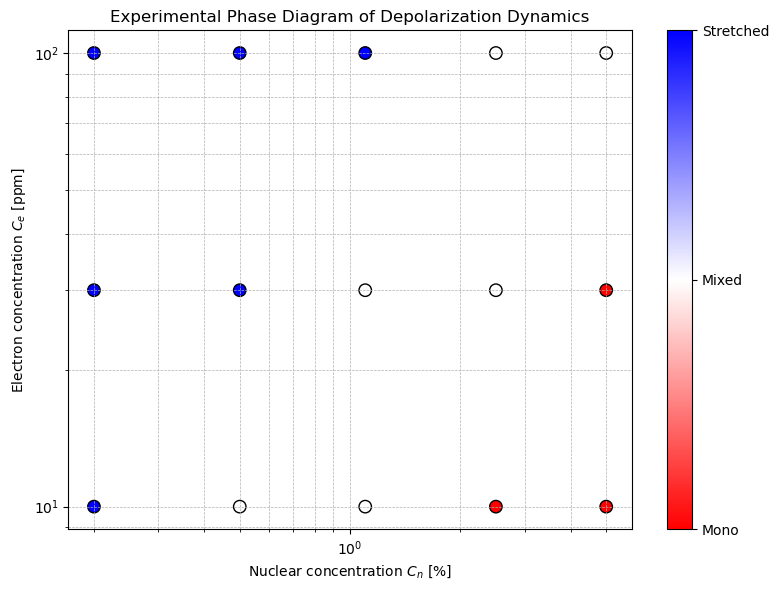

In [104]:
import glob
import re

# Storage arrays
ce_list = []
cn_list = []
decay_shape_ratio = []

# Search for all relaxation data files
for file in glob.glob("NC=*%_EC=*ppm_RelaxationRates.npz"):
    # Parse concentrations using regex
    match = re.search(r"NC=(\d+\.?\d*)%_EC=(\d+\.?\d*)ppm", file)
    if not match:
        continue
    cn = float(match.group(1))  # Nuclear concentration in %
    ce = float(match.group(2))  # Electron concentration in ppm

    # Load the rates
    data = np.load(file)
    R_p = data['S_avg'].item()  # Stretched exponential rate (inside sqrt)
    R_d = data['M_avg'].item()  # Monoexponential rate

#     # Skip invalid entries
#     if R_p <= 0 or R_d <= 0:
#         continue

    # Compute the shape ratio
    ratio = R_p / R_d

    # Store values
    ce_list.append(ce)
    cn_list.append(cn)
    decay_shape_ratio.append(ratio)

# Convert to numpy arrays
ce_array = np.array(ce_list)
cn_array = np.array(cn_list)
ratio_array = np.array(decay_shape_ratio)

# Classify into phases
phase = np.zeros_like(ratio_array)
phase[ratio_array < 0.3] = 0   # mono
phase[(ratio_array >= 0.3) & (ratio_array <= 3.33)] = 1  # mixed
phase[ratio_array > 3.33] = 2     # stretched

# Plot
plt.figure(figsize=(8, 6))
scatter = plt.scatter(cn_array, ce_array, c=phase, cmap='bwr_r', s=80, edgecolors='k')

# Formatting
cbar = plt.colorbar(scatter, ticks=[0, 1, 2])
cbar.ax.set_yticklabels(['Mono', 'Mixed', 'Stretched'])

plt.xscale('log')
plt.yscale('log')
plt.xlabel('Nuclear concentration $C_n$ [%]')
plt.ylabel('Electron concentration $C_e$ [ppm]')
plt.title('Experimental Phase Diagram of Depolarization Dynamics')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

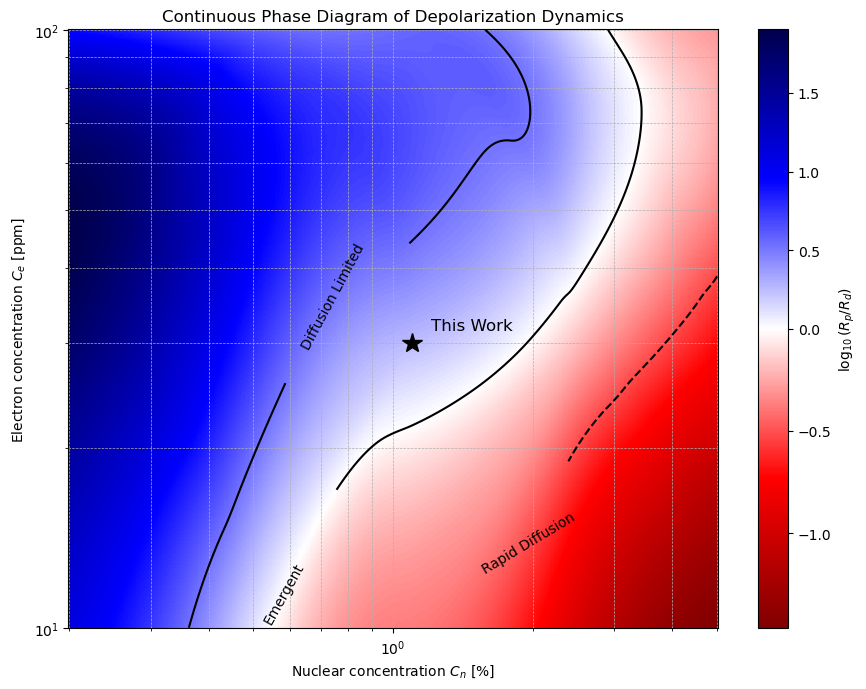

In [446]:
import glob
import re
from scipy.interpolate import griddata
from matplotlib.colors import TwoSlopeNorm

# 1. Load and parse data
ce_list = []
cn_list = []
decay_shape_ratio = []

for file in glob.glob("NC=*%_EC=*ppm_RelaxationRates.npz"):
    match = re.search(r"NC=(\d+\.?\d*)%_EC=(\d+\.?\d*)ppm", file)
    if not match:
        continue
    cn = float(match.group(1))  # Nuclear concentration (%)
    ce = float(match.group(2))  # Electron concentration (ppm)

    data = np.load(file)
    R_p = data['S_avg'].item() / 1000  # Stretched exponential component (inside sqrt)
    R_d = data['M_avg'].item() / 1000 # Monoexponential component

    if R_p <= 0 or R_d <= 0:
        continue

    ratio = R_p / R_d  # Decay shape ratio
    ce_list.append(ce)
    cn_list.append(cn)
    decay_shape_ratio.append(ratio)

# 2. Prepare data
ce_array = np.array(ce_list)
cn_array = np.array(cn_list)
ratio_array = np.array(decay_shape_ratio)

# 3. Interpolate onto grid
# Define log-scale grid
ce_grid = np.logspace(np.log10(min(ce_array)), np.log10(max(ce_array)), 500)
cn_grid = np.logspace(np.log10(min(cn_array)), np.log10(max(cn_array)), 500)
Ce_grid, Cn_grid = np.meshgrid(ce_grid, cn_grid)

# Interpolate log10(ratio) for smoother visualization
log_ratio = np.log10(ratio_array)
log_ratio_grid = griddata(
    points=(ce_array, cn_array),
    values=log_ratio,
    xi=(Ce_grid, Cn_grid),
    method='cubic'
)

# 4. Plot as heatmap
plt.figure(figsize=(9, 7))
norm = TwoSlopeNorm(vmin=np.nanmin(log_ratio_grid), vcenter=0, vmax=np.nanmax(log_ratio_grid))
im = plt.pcolormesh(Cn_grid, Ce_grid, log_ratio_grid, shading='auto', cmap='seismic_r', norm=norm)
cbar = plt.colorbar(im)
cbar.set_label(r'$\log_{10} \left( R_p / R_d \right)$')

# 5. Overlay contour lines for phase boundaries
levels = [np.log10(0.3), 0, np.log10(3.33)]  # boundaries for mono/mixed/stretched
contour = plt.contour(Cn_grid, Ce_grid, log_ratio_grid, levels=levels, colors='k', linewidths=1.5)
plt.clabel(contour, fmt={levels[0]: 'Rapid Diffusion', levels[1]: 'Emergent', levels[2]: 'Diffusion Limited'}, fontsize=10)

# Plot the star
plt.plot(1.1, 30, marker='*', color='black', markersize=15, label='this work')
# Add a label near the star
plt.text(1.1 * 1.1, 30 * 1.05, 'This Work', color='black', fontsize=12)

# 6. Plot formatting
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Nuclear concentration $C_n$ [%]')
plt.ylabel('Electron concentration $C_e$ [ppm]')
plt.title('Continuous Phase Diagram of Depolarization Dynamics')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

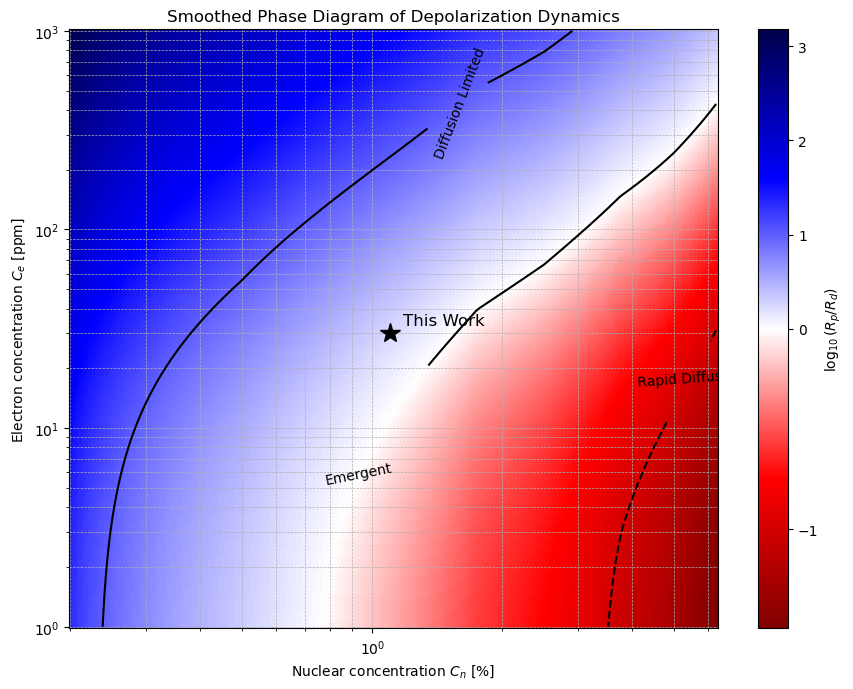

In [30]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import TwoSlopeNorm
from scipy.interpolate import RegularGridInterpolator
import glob
import re

# ----- Load the electron scaling data -----
data = np.loadtxt('ev_scaling.txt')
x = data[:, 0]       # Electron concentration (ppm)
Rp_data = data[:, 2] # Column 3: S_avg (Rp)
Rd_data = data[:, 4] / 2  # Column 5: M_avg (Rd)

# Fit Rp to Rp = a*x^2 + b*x (no intercept)
X_Rp = np.vstack([x**2, x]).T
coeffs_Rp, _, _, _ = np.linalg.lstsq(X_Rp, Rp_data, rcond=None)

# Fit Rd to Rd = a*x (no intercept)
X_Rd = x[:, None]
coeffs_Rd, _, _, _ = np.linalg.lstsq(X_Rd, Rd_data, rcond=None)

def scale_Rp(x_val):
    return coeffs_Rp[0] * x_val**2 + coeffs_Rp[1] * x_val

def scale_Rd(x_val):
    return coeffs_Rd[0] * x_val

# ----- Electron concentration range (ppm) -----
electron_concs = np.logspace(0, 3, 100)  # 1 to 1000 ppm

# ----- Load all nuclear concentration data -----
files = sorted(glob.glob("*%_RelaxationRates_PBC.npz"))

nuclear_concs = []
Rd_grid = []
Rp_grid = []

for file in files:
    match = re.match(r"([0-9.]+)%_RelaxationRates_PBC\.npz", file)
    if not match:
        continue
    nuc_conc = float(match.group(1))
    data = np.load(file)
    
    M_avg = data["M_avg"]
    S_avg = data["S_avg"]

    Rd_at_30ppm = scale_Rd(30)
    Rp_at_30ppm = scale_Rp(30)

    Rd_scaled = (M_avg / Rd_at_30ppm) * scale_Rd(electron_concs)
    Rp_scaled = (S_avg / Rp_at_30ppm) * scale_Rp(electron_concs)

    Rd_grid.append(Rd_scaled)
    Rp_grid.append(Rp_scaled)
    nuclear_concs.append(nuc_conc)

# Convert to arrays and sort
nuclear_concs = np.array(nuclear_concs)
Rd_grid = np.array(Rd_grid)
Rp_grid = np.array(Rp_grid)

sort_idx = np.argsort(nuclear_concs)
nuclear_concs = nuclear_concs[sort_idx]
Rd_grid = Rd_grid[sort_idx]
Rp_grid = Rp_grid[sort_idx]

# ----- Interpolate onto finer grid -----
Ce_fine = np.logspace(0, 3, 200)
Cn_fine = np.logspace(np.log10(nuclear_concs.min()), np.log10(nuclear_concs.max()), 200)
Ce_grid_fine, Cn_grid_fine = np.meshgrid(Ce_fine, Cn_fine)

interp_points = np.stack([Cn_grid_fine.ravel(), Ce_grid_fine.ravel()], axis=-1)

interp_Rd = RegularGridInterpolator((nuclear_concs, electron_concs), Rd_grid, bounds_error=False, fill_value=np.nan)
interp_Rp = RegularGridInterpolator((nuclear_concs, electron_concs), Rp_grid, bounds_error=False, fill_value=np.nan)

Rd_grid_fine = interp_Rd(interp_points).reshape(Ce_grid_fine.shape)
Rp_grid_fine = interp_Rp(interp_points).reshape(Ce_grid_fine.shape)

# ----- Calculate log10(Rp / Rd) -----
log_ratio_grid = np.log10(Rp_grid_fine / Rd_grid_fine)

# ----- Plot phase diagram -----
plt.figure(figsize=(9, 7))
norm = TwoSlopeNorm(vmin=np.nanmin(log_ratio_grid), vcenter=0, vmax=np.nanmax(log_ratio_grid))
im = plt.pcolormesh(Cn_grid_fine, Ce_grid_fine, log_ratio_grid, shading='auto', cmap='seismic_r', norm=norm)
cbar = plt.colorbar(im)
cbar.set_label(r'$\log_{10} \left( R_p / R_d \right)$')

# Contour lines
levels = [np.log10(0.1), 0, np.log10(10)]
contour = plt.contour(Cn_grid_fine, Ce_grid_fine, log_ratio_grid, levels=levels, colors='k', linewidths=1.5)
plt.clabel(contour, fmt={
    levels[0]: 'Rapid Diffusion',
    levels[1]: 'Emergent',
    levels[2]: 'Diffusion Limited'
}, fontsize=10)

# Mark your own data point
plt.plot(1.1, 30, marker='*', color='black', markersize=15)
plt.text(1.1 * 1.07, 30 * 1.1, 'This Work', color='black', fontsize=12)

# Final formatting
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Nuclear concentration $C_n$ [%]')
plt.ylabel('Electron concentration $C_e$ [ppm]')
plt.title('Smoothed Phase Diagram of Depolarization Dynamics')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()


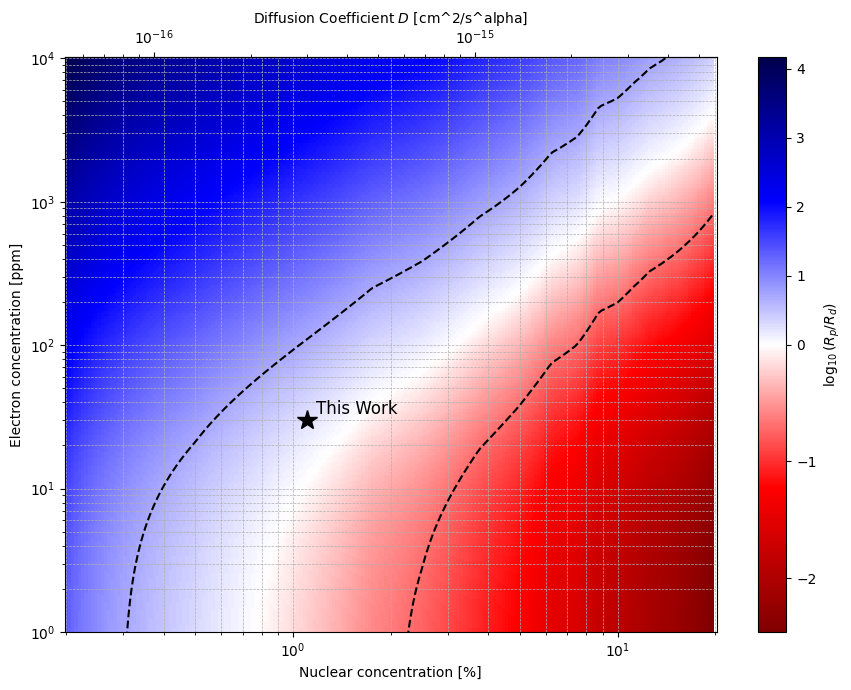

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import TwoSlopeNorm
from scipy.interpolate import RegularGridInterpolator
import glob
import re

# ----- Load the electron scaling data -----
data = np.loadtxt('ev_scaling.txt')
x = data[:, 0]       # Electron concentration (ppm)
Rp_data = data[:, 2] # Column 3: S_avg (Rp)
Rd_data = data[:, 4] / 2  # Column 5: M_avg (Rd)

# Fit Rp to Rp = a*x^2 + b*x (no intercept)
X_Rp = np.vstack([x**2, x]).T
coeffs_Rp, _, _, _ = np.linalg.lstsq(X_Rp, Rp_data, rcond=None)

# Fit Rd to Rd = a*x (no intercept)
X_Rd = x[:, None]
coeffs_Rd, _, _, _ = np.linalg.lstsq(X_Rd, Rd_data, rcond=None)

def scale_Rp(x_val):
    return coeffs_Rp[0] * x_val**2 + coeffs_Rp[1] * x_val

def scale_Rd(x_val):
    return coeffs_Rd[0] * x_val

# ----- Electron concentration range (ppm) -----
electron_concs = np.logspace(0, 4, 100)  # 1 to 1000 ppm

# ----- Load all nuclear concentration data -----
files = sorted(glob.glob("*%_RelaxationRates_PBC.npz"))

nuclear_concs = []
Rd_grid = []
Rp_grid = []

for file in files:
    match = re.match(r"([0-9.]+)%_RelaxationRates_PBC\.npz", file)
    if not match:
        continue
    nuc_conc = float(match.group(1))
    data = np.load(file)
    
    M_avg = data["M_avg"]
    S_avg = data["S_avg"]

    Rd_at_30ppm = scale_Rd(30)
    Rp_at_30ppm = scale_Rp(30)

    Rd_scaled = (M_avg / Rd_at_30ppm) * scale_Rd(electron_concs)
    Rp_scaled = (S_avg / Rp_at_30ppm) * scale_Rp(electron_concs)

    Rd_grid.append(Rd_scaled)
    Rp_grid.append(Rp_scaled)
    nuclear_concs.append(nuc_conc)

# Convert to arrays and sort
nuclear_concs = np.array(nuclear_concs)
Rd_grid = np.array(Rd_grid)
Rp_grid = np.array(Rp_grid)

sort_idx = np.argsort(nuclear_concs)
nuclear_concs = nuclear_concs[sort_idx]
Rd_grid = Rd_grid[sort_idx]
Rp_grid = Rp_grid[sort_idx]

# ----- Interpolate onto finer grid -----
Ce_fine = np.logspace(0, 4, 200)
Cn_fine = np.logspace(np.log10(nuclear_concs.min()), np.log10(nuclear_concs.max()), 200)
Ce_grid_fine, Cn_grid_fine = np.meshgrid(Ce_fine, Cn_fine)

interp_points = np.stack([Cn_grid_fine.ravel(), Ce_grid_fine.ravel()], axis=-1)

interp_Rd = RegularGridInterpolator((nuclear_concs, electron_concs), Rd_grid, bounds_error=False, fill_value=np.nan)
interp_Rp = RegularGridInterpolator((nuclear_concs, electron_concs), Rp_grid, bounds_error=False, fill_value=np.nan)

Rd_grid_fine = interp_Rd(interp_points).reshape(Ce_grid_fine.shape)
Rp_grid_fine = interp_Rp(interp_points).reshape(Ce_grid_fine.shape)

# ----- Calculate log10(Rp / Rd) -----
log_ratio_grid = np.log10(Rp_grid_fine / Rd_grid_fine)


# D values (diffusion coefficients corresponding to nuclear concentrations)
D_values = np.array([5.34526749e-01, 1.60904227e+00, 3.86423033e+00, 6.39162978e+00,
 1.00951956e+01, 1.70236678e+01, 2.47419477e+01, 3.39870953e+01,
 4.55056865e+01, 5.59753574e+01, 6.49380121e+01, 7.64216797e+01,
 8.62328072e+01, 1.05832854e+02, 1.51574868e+02])
D_values = D_values[sort_idx] * 1e-16

from scipy.interpolate import interp1d
# Interpolation: nuclear conc <-> D
conc_to_D = interp1d(nuclear_concs, D_values, kind='linear', fill_value='extrapolate')
D_to_conc = interp1d(D_values, nuclear_concs, kind='linear', fill_value='extrapolate')


fig, ax = plt.subplots(figsize=(9, 7))
norm = TwoSlopeNorm(vmin=np.nanmin(log_ratio_grid), vcenter=0, vmax=np.nanmax(log_ratio_grid))
im = ax.pcolormesh(Cn_grid_fine, Ce_grid_fine, log_ratio_grid, shading='auto', cmap='seismic_r', norm=norm)
cbar = fig.colorbar(im, ax=ax)
cbar.set_label(r'$\log_{10} \left( R_p / R_d \right)$')

# Contour lines
levels = [np.log10(0.2), np.log10(5)]
contour = ax.contour(Cn_grid_fine, Ce_grid_fine, log_ratio_grid, levels=levels, colors='k', linewidths=1.5,
                     linestyles='dashed')
# ax.clabel(contour, fmt={
#     levels[0]: 'Rapid Diffusion',
#     levels[1]: 'Emergent',
#     levels[2]: 'Diffusion Limited'
# }, fontsize=10)

# Marker
ax.plot(1.1, 30, marker='*', color='black', markersize=15)
ax.text(1.1 * 1.07, 30 * 1.1, 'This Work', color='black', fontsize=12)

# Main axis formatting
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('Nuclear concentration [%]')
ax.set_ylabel('Electron concentration [ppm]')
# ax.set_title('Smoothed Phase Diagram of Depolarization Dynamics')
ax.grid(True, which='both', linestyle='--', linewidth=0.5)

# ---- Add top x-axis for diffusion coefficient D ----
secax = ax.secondary_xaxis('top', functions=(conc_to_D, D_to_conc))
secax.set_xlabel('Diffusion Coefficient $D$ [cm^2/s^alpha]')
secax.set_xscale('log')

plt.tight_layout()
plt.show()

# fig.savefig("C:\\Users\\Suber\\Desktop\\Relaxation_Landscape.eps", format='eps', dpi=300)

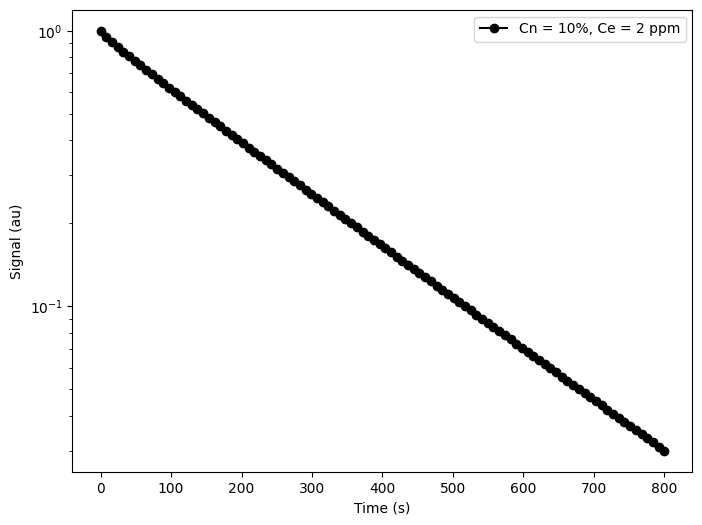

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


In [37]:
Cn_val = 10
Ce_val = 2  

Rd = interp_Rd([[Cn_val, Ce_val]])[0] / 1000
Rp = interp_Rp([[Cn_val, Ce_val]])[0] / 1000

t = np.linspace(0, 800, 100)

signal = np.exp(-Rd * t) * np.exp(-np.sqrt(Rp * t))

fig = plt.figure(figsize=(8, 6))
plt.plot(t, signal, '-o', label=f"Cn = {Cn_val}%, Ce = {Ce_val} ppm", color='black')
plt.xlabel('Time (s)')
plt.ylabel('Signal (au)')
plt.yscale('log')
plt.legend()
plt.show()

# fig.savefig("C:\\Users\\Suber\\Desktop\\CardinalPointMono.eps", format='eps', dpi=300)

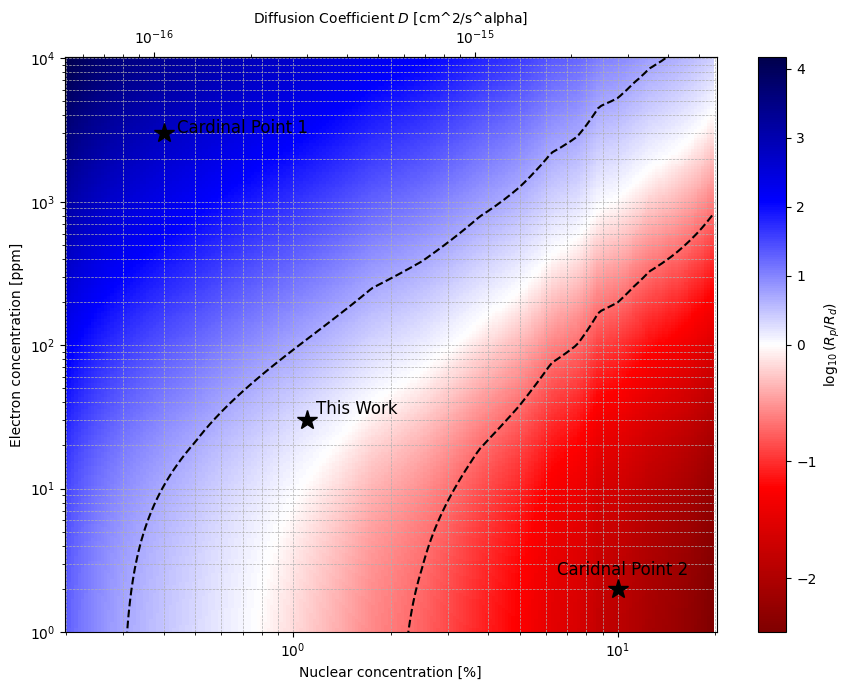

In [44]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import TwoSlopeNorm
from scipy.interpolate import RegularGridInterpolator
import glob
import re

# ----- Load the electron scaling data -----
data = np.loadtxt('ev_scaling.txt')
x = data[:, 0]       # Electron concentration (ppm)
Rp_data = data[:, 2] # Column 3: S_avg (Rp)
Rd_data = data[:, 4] / 2  # Column 5: M_avg (Rd)

# Fit Rp to Rp = a*x^2 + b*x (no intercept)
X_Rp = np.vstack([x**2, x]).T
coeffs_Rp, _, _, _ = np.linalg.lstsq(X_Rp, Rp_data, rcond=None)

# Fit Rd to Rd = a*x (no intercept)
X_Rd = x[:, None]
coeffs_Rd, _, _, _ = np.linalg.lstsq(X_Rd, Rd_data, rcond=None)

def scale_Rp(x_val):
    return coeffs_Rp[0] * x_val**2 + coeffs_Rp[1] * x_val

def scale_Rd(x_val):
    return coeffs_Rd[0] * x_val

# ----- Electron concentration range (ppm) -----
electron_concs = np.logspace(0, 4, 100)  # 1 to 1000 ppm

# ----- Load all nuclear concentration data -----
files = sorted(glob.glob("*%_RelaxationRates_PBC.npz"))

nuclear_concs = []
Rd_grid = []
Rp_grid = []

for file in files:
    match = re.match(r"([0-9.]+)%_RelaxationRates_PBC\.npz", file)
    if not match:
        continue
    nuc_conc = float(match.group(1))
    data = np.load(file)
    
    M_avg = data["M_avg"]
    S_avg = data["S_avg"]

    Rd_at_30ppm = scale_Rd(30)
    Rp_at_30ppm = scale_Rp(30)

    Rd_scaled = (M_avg / Rd_at_30ppm) * scale_Rd(electron_concs)
    Rp_scaled = (S_avg / Rp_at_30ppm) * scale_Rp(electron_concs)

    Rd_grid.append(Rd_scaled)
    Rp_grid.append(Rp_scaled)
    nuclear_concs.append(nuc_conc)

# Convert to arrays and sort
nuclear_concs = np.array(nuclear_concs)
Rd_grid = np.array(Rd_grid)
Rp_grid = np.array(Rp_grid)

sort_idx = np.argsort(nuclear_concs)
nuclear_concs = nuclear_concs[sort_idx]
Rd_grid = Rd_grid[sort_idx]
Rp_grid = Rp_grid[sort_idx]

# ----- Interpolate onto finer grid -----
Ce_fine = np.logspace(0, 4, 200)
Cn_fine = np.logspace(np.log10(nuclear_concs.min()), np.log10(nuclear_concs.max()), 200)
Ce_grid_fine, Cn_grid_fine = np.meshgrid(Ce_fine, Cn_fine)

interp_points = np.stack([Cn_grid_fine.ravel(), Ce_grid_fine.ravel()], axis=-1)

interp_Rd = RegularGridInterpolator((nuclear_concs, electron_concs), Rd_grid, bounds_error=False, fill_value=np.nan)
interp_Rp = RegularGridInterpolator((nuclear_concs, electron_concs), Rp_grid, bounds_error=False, fill_value=np.nan)

Rd_grid_fine = interp_Rd(interp_points).reshape(Ce_grid_fine.shape)
Rp_grid_fine = interp_Rp(interp_points).reshape(Ce_grid_fine.shape)

# ----- Calculate log10(Rp / Rd) -----
log_ratio_grid = np.log10(Rp_grid_fine / Rd_grid_fine)


# D values (diffusion coefficients corresponding to nuclear concentrations)
D_values = np.array([5.34526749e-01, 1.60904227e+00, 3.86423033e+00, 6.39162978e+00,
 1.00951956e+01, 1.70236678e+01, 2.47419477e+01, 3.39870953e+01,
 4.55056865e+01, 5.59753574e+01, 6.49380121e+01, 7.64216797e+01,
 8.62328072e+01, 1.05832854e+02, 1.51574868e+02])
D_values = D_values[sort_idx] * 1e-16

from scipy.interpolate import interp1d
# Interpolation: nuclear conc <-> D
conc_to_D = interp1d(nuclear_concs, D_values, kind='linear', fill_value='extrapolate')
D_to_conc = interp1d(D_values, nuclear_concs, kind='linear', fill_value='extrapolate')


fig, ax = plt.subplots(figsize=(9, 7))
norm = TwoSlopeNorm(vmin=np.nanmin(log_ratio_grid), vcenter=0, vmax=np.nanmax(log_ratio_grid))
im = ax.pcolormesh(Cn_grid_fine, Ce_grid_fine, log_ratio_grid, shading='auto', cmap='seismic_r', norm=norm)
cbar = fig.colorbar(im, ax=ax)
cbar.set_label(r'$\log_{10} \left( R_p / R_d \right)$')

# Contour lines
levels = [np.log10(0.2), np.log10(5)]
contour = ax.contour(Cn_grid_fine, Ce_grid_fine, log_ratio_grid, levels=levels, colors='k', linewidths=1.5,
                     linestyles='dashed')
# ax.clabel(contour, fmt={
#     levels[0]: 'Rapid Diffusion',
#     levels[1]: 'Emergent',
#     levels[2]: 'Diffusion Limited'
# }, fontsize=10)

# Marker
ax.plot(1.1, 30, marker='*', color='black', markersize=15)
ax.text(1.1 * 1.07, 30 * 1.1, 'This Work', color='black', fontsize=12)

ax.plot(0.4, 3000, marker='*', color='black', markersize=15)
ax.text(0.4 * 1.1, 3000 * 1.01, 'Cardinal Point 1', color='black', fontsize=12)

# Marker
ax.plot(10, 2, marker='*', color='black', markersize=15)
ax.text(6.5, 2.5, 'Caridnal Point 2', color='black', fontsize=12)

# Main axis formatting
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('Nuclear concentration [%]')
ax.set_ylabel('Electron concentration [ppm]')
# ax.set_title('Smoothed Phase Diagram of Depolarization Dynamics')
ax.grid(True, which='both', linestyle='--', linewidth=0.5)

# ---- Add top x-axis for diffusion coefficient D ----
secax = ax.secondary_xaxis('top', functions=(conc_to_D, D_to_conc))
secax.set_xlabel('Diffusion Coefficient $D$ [cm^2/s^alpha]')
secax.set_xscale('log')

plt.tight_layout()
plt.show()

# fig.savefig("C:\\Users\\Suber\\Desktop\\Relaxation_Landscape_CardinalPoints.eps", format='eps', dpi=300)